In [1]:
import os
import torch
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from matplotlib.patches import Rectangle
import seaborn as sns
import pickle
import sys
sys.path.append("../")
from conf import settings
import utils
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
target_s_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Estimation Accuracy for Dataset Similarity 

In [2]:
similarity_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "same_dist.pkl"), "rb"))
mix_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "diff_dist.pkl"), "rb"))
shard_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "same_dist_shards.pkl"), "rb"))
low_epoch_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "low_epoch.pkl"), "rb"))
gauss_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "gauss.pkl"), "rb"))
color_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "color.pkl"), "rb"))
gauss_color_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "gauss_color.pkl"), "rb"))

## Output distance - dataset similarity $s$ plot

In [3]:
# vic_mean = similarity_outputs['int1.0'].mean(dim=0)
df_dict = {'$s^d$': [], 'ModelID': [], 'Output Distance':[], 'Distance Type':[]}

for s in target_s_list:
    key = f'int{s}'
    for k, v in enumerate(similarity_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Lookup Table'] * len(diff))
    for k, v in enumerate(shard_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Heuristic'] * len(diff))
    for k, v in enumerate(mix_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Adversary'] * len(diff))
    
df_basic = pd.DataFrame.from_dict(df_dict)

### Case: Low Epoch (adversary's epoch = 60)

In [4]:
# vic_mean = similarity_outputs['int1.0'].mean(dim=0)
df_dict = {'$s^d$': [], 'ModelID': [], 'Output Distance':[], 'Distance Type':[]}

for s in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    key = f'int{s}'
    for k, v in enumerate(similarity_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Victim'] * len(diff))
    for k, v in enumerate(shard_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Heuristic'] * len(diff))
    for k, v in enumerate(low_epoch_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Fewer Epoch'] * len(diff))
df_low_epoch = pd.DataFrame.from_dict(df_dict)

### Case: Adaptive transformation with gaussian blur and color jitter

In [5]:
# vic_mean = similarity_outputs['int1.0'].mean(dim=0)
df_dict = {'$s^d$': [], 'ModelID': [], 'Output Distance':[], 'Distance Type':[]}

for s in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    key = f'int{s}'
    for k, v in enumerate(gauss_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Gauss'] * len(diff))
    for k, v in enumerate(color_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Color'] * len(diff))
    for k, v in enumerate(gauss_color_outputs[key]):
        diff = torch.sum((v - similarity_outputs['vic'][k])**2, dim=1).reshape(-1)
        df_dict['$s^d$'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Output Distance'].extend(diff.tolist())
        df_dict['Distance Type'].extend(['Gauss-Color'] * len(diff))
df_adaptive = pd.DataFrame.from_dict(df_dict)

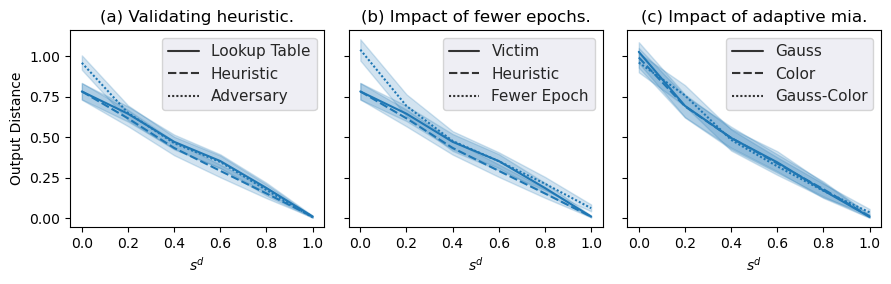

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True)
fig.set_size_inches(9, 3)
sns.set_theme(style="darkgrid")

sns.lineplot(x='$s^d$', y='Output Distance', style='Distance Type', data=df_basic, ax=ax1)
ax1.set_title("(a) Validating heuristic.")
ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.legend()

sns.lineplot(x='$s^d$', y='Output Distance', style='Distance Type', data=df_low_epoch, ax=ax2)
# ax2.set_ylabel("")
ax2.set_title("(b) Impact of fewer epochs.")
ax2.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.legend()

sns.lineplot(x='$s^d$', y='Output Distance', style='Distance Type', data=df_adaptive, ax=ax3)
# ax2.set_ylabel("")
ax3.set_title("(c) Impact of adaptive mia.")
ax3.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax3.legend()

plt.tight_layout()
# plt.savefig('figures/case_study_model_distance.pdf', bbox_inches='tight')
plt.show()

## Compute $\mu$, $\epsilon$

In [7]:
def estimation_accuracy(surrogate_outputs, query_outputs, test_s_list, true_s_list, copy_num=10):
    test_inter_list = ['int{}'.format(i) for i in test_s_list]
    true_inter_list = ['int{}'.format(i) for i in true_s_list]
    all_diff = []
    
    for k in range(copy_num):
        for i, key_true in enumerate(true_inter_list):
            tmp = np.zeros((len(test_inter_list), ))
            # print(k, key_true, "*")
            for j, key_test in enumerate(test_inter_list):
                dist_mean = torch.sum((query_outputs[key_true][k] - surrogate_outputs['vic'][k])**2, dim=1).cpu().numpy()
                dist_test = torch.sum((surrogate_outputs[key_test][k] - surrogate_outputs['vic'][k])**2, dim=1).cpu().numpy()
                stats, pv = sps.ttest_ind(dist_mean, dist_test)
                tmp[j] = np.abs(stats)

            pred_s = test_s_list[tmp.argmin(axis=0).item()]
            true_s = true_s_list[i]
            
            all_diff.append(np.round(np.abs(pred_s - true_s), 2))
            # if all_diff[-1] > 0:
                
                # print(true_s, pred_s)

    all_diff = np.array(all_diff)
    mu_epsilon_summary = {}
    for mu in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        mu_epsilon_summary[mu] = len(np.where(all_diff >= mu)[0]) / len(all_diff)
    return mu_epsilon_summary, all_diff
 

In [8]:
mu_epsilon_summary, all_diff = estimation_accuracy(similarity_outputs, mix_outputs, target_s_list, target_s_list, 10)
print(mu_epsilon_summary)

{0.1: 0.1, 0.2: 0.1, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


In [9]:
mu_epsilon_summary, all_diff = estimation_accuracy(similarity_outputs, low_epoch_outputs, target_s_list, target_s_list, 5)
print(mu_epsilon_summary)

{0.1: 0.2, 0.2: 0.2, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


In [10]:
mu_epsilon_summary, all_diff = estimation_accuracy(similarity_outputs, color_outputs, target_s_list, target_s_list, 5)
print(mu_epsilon_summary)

{0.1: 0.1, 0.2: 0.1, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


In [11]:
mu_epsilon_summary, all_diff = estimation_accuracy(similarity_outputs, gauss_outputs, target_s_list, target_s_list, 5)
print(mu_epsilon_summary)

{0.1: 0.16666666666666666, 0.2: 0.16666666666666666, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


In [12]:
mu_epsilon_summary, all_diff = estimation_accuracy(similarity_outputs, gauss_color_outputs, target_s_list, target_s_list, 5)
print(mu_epsilon_summary)

{0.1: 0.2, 0.2: 0.2, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


### Case: Smaller adversary dataset


$|\mathcal{S}_\mathcal{A}|/|\mathcal{S}_\mathcal{V}|= 0.5$

In [13]:
small_adv_dst2_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "small_adv_dst2.pkl"), "rb"))
mu_epsilon_summary, all_diff = estimation_accuracy(similarity_outputs, small_adv_dst2_outputs, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], 10)
print(mu_epsilon_summary)

{0.1: 0.8, 0.2: 0.36666666666666664, 0.3: 0.03333333333333333, 0.4: 0.016666666666666666, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


$|\mathcal{S}_\mathcal{A}|/|\mathcal{S}_\mathcal{V}|= 0.1$

In [14]:
small_adv_dst10_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "small_adv_dst10.pkl"), "rb"))
mu_epsilon_summary, all_diff = estimation_accuracy(similarity_outputs, small_adv_dst10_outputs, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.0, 0.1], 10)
print(mu_epsilon_summary)

{0.1: 0.55, 0.2: 0.05, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


### Case: Larger adversary dataset

$|\mathcal{S}_\mathcal{A}|/|\mathcal{S}_\mathcal{V}|= 2$

In [15]:
large_sur_dst2_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "large_adv_dst_same_dist2.pkl"), "rb"))
large_adv_dst2_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "large_adv_dst_diff_dist2.pkl"), "rb"))
mu_epsilon_summary, all_diff = estimation_accuracy(large_sur_dst2_outputs, large_adv_dst2_outputs, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 10)
print(mu_epsilon_summary)

{0.1: 0.05, 0.2: 0.05, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


$|\mathcal{S}_\mathcal{A}|/|\mathcal{S}_\mathcal{V}|= 10$

In [16]:
large_sur_dst10_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "large_adv_dst_same_dist10.pkl"), "rb"))
large_adv_dst10_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity", "large_adv_dst_diff_dist10.pkl"), "rb"))

# large_sur_dst10_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity0", "small_set10_similarity.pkl"), "rb"))
# large_sur_dst10_outputs['vic'] = large_sur_dst10_outputs['int1.0']
# large_adv_dst10_outputs = pickle.load(open(os.path.join(settings.CASE_STUDY_RESULT_PATH, "dataset_similarity0", "small_set10_utk_mix.pkl"), "rb"))
mu_epsilon_summary, all_diff = estimation_accuracy(large_sur_dst10_outputs, large_adv_dst10_outputs, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 10)
print(mu_epsilon_summary)

{0.1: 0.5833333333333334, 0.2: 0.5833333333333334, 0.3: 0.03333333333333333, 0.4: 0.03333333333333333, 0.5: 0.016666666666666666, 0.6: 0.016666666666666666, 0.7: 0.016666666666666666, 0.8: 0.016666666666666666, 0.9: 0.0}


# MIA as Baseline 


In [17]:
import mia
from sklearn.metrics import accuracy_score
from similarity_facial_predict import verification_set, process
target_s_array = np.array(target_s_list)

In [18]:
mc_n_sample = 100
dst_ratio =1
select_idx, verify_tensor, num_classes, verify_label = verification_set(mc_n_sample, dst_ratio)
mean_std_dict = process("same_dist", dst_ratio)

X_tensor1, y_tensor1 = pickle.load(open(os.path.join(settings.DATA_PATH, 'facial_attribute', 'fairface_set1_tensor.pkl'), 'rb'))
X_tensor2, y_tensor2 = pickle.load(open(os.path.join(settings.DATA_PATH, 'facial_attribute', 'fairface_set_rest_tensor.pkl'), 'rb'))
X_tensor2, y_tensor2 = X_tensor2[:len(X_tensor1)], y_tensor2[:len(X_tensor1)]
train_loader = torch.utils.data.DataLoader(utils.SubTrainDataset(X_tensor1, y_tensor1), batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(utils.SubTrainDataset(X_tensor2, y_tensor2), batch_size=1024, shuffle=False)

## Determine the threshold

Get loss threshold from models trained on victim dataset

In [19]:
vic_model_thresholds = []
advantages = []
model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, "resnet101_facial_vic")
for name in sorted(os.listdir(model_pth_path)):
    model = getattr(models, 'resnet101')(num_classes=num_classes)
    model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
    model.eval()
    model = nn.Sequential(transforms.Normalize(*mean_std_dict['int1.0']), model).cuda()
    train_losses, test_losses = mia.return_losses(model, train_loader, test_loader, device='cuda')
    best_threshold, _, _, adv = mia.apply_best_attacks(train_losses, test_losses, select_num=1000)
    vic_model_thresholds.append(best_threshold)
    advantages.append(adv)
print(vic_model_thresholds)

[0.09012060122767382, 0.03080662293866001, 0.007194374206080377, 0.0024051174569462187, 0.003937495935104677, 0.0009540294593823517, 0.002160141134517331, 0.005287242197419957, 0.01508379732353865, 0.0031439800172844553]


## Apply the attack on adversary model
Load adversary model

In [20]:
attacker_model_output = {}
inter_names = [f"regnet_y_8gf_facial_diff_dist_{s}" for s in target_s_list]
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, intersection)
    for name in os.listdir(model_pth_path):
        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes)
        model.load_state_dict(torch.load(os.path.join(model_pth_path, name),  map_location='cpu'))
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*mean_std_dict[inter_propor]), model)
        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    attacker_model_output[inter_propor] = model_predicts

MIA success rate as similarity. Round to target s values to compare on the same precision.

In [21]:
def mia_estimation_accuracy(attacker_model_output, model_thresholds, dst_ratio=1):
    all_diff = []
    mu_epsilon_dict = {}
    for idx_inter, (inter_propor, outputs) in enumerate(attacker_model_output.items()):
        true_s = float(inter_propor[-3:]) / dst_ratio
        for i, output in enumerate(outputs):
            test_memberships = mia.yeom_mi_attack(output.numpy(), model_thresholds[i])
            acc = accuracy_score(np.ones(len(output)), test_memberships)
            pred_s = target_s_array[np.argmin(np.abs(acc - target_s_array))]
            mu = np.round(np.abs(pred_s - true_s), 2)
            all_diff.append(mu)

    all_diff = np.array(all_diff)
    mu_epsilon_summary = {}
    for mu in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        mu_epsilon_summary[mu] = len(np.where(all_diff >= mu)[0]) / len(all_diff)
    return mu_epsilon_summary, all_diff

In [22]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(attacker_model_output, vic_model_thresholds)
print(mu_epsilon_summary)

{0.1: 0.4, 0.2: 0.4, 0.3: 0.1, 0.4: 0.1, 0.5: 0.016666666666666666, 0.6: 0.016666666666666666, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


## Low epoch

In [23]:

low_epoch_attacker_model_output = {}
inter_names = ["regnet_y_8gf_facial_diff_dist_{}".format(s) for s in target_s_list[::-1]]
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'low_epoch', 'epoch60', intersection)
    for name in os.listdir(model_pth_path):
        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes)
        model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*mean_std_dict[inter_propor]), model)
        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    low_epoch_attacker_model_output[inter_propor] = model_predicts

In [24]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(low_epoch_attacker_model_output, vic_model_thresholds)
print(mu_epsilon_summary)

{0.1: 0.6666666666666666, 0.2: 0.6666666666666666, 0.3: 0.23333333333333334, 0.4: 0.23333333333333334, 0.5: 0.03333333333333333, 0.6: 0.03333333333333333, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


## Adaptive trans
### color

In [25]:

adapt_color_attacker_model_output = {}
inter_names = [f"regnet_y_8gf_adaptive_color_facial_diff_dist_{s}" for s in target_s_list[::-1]]
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'adaptive_trans', intersection)
    for name in os.listdir(model_pth_path):
        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes)
        net_dict = torch.load(os.path.join(model_pth_path, name), map_location='cpu')
        model.load_state_dict(net_dict['net_sd'])
        model.eval()
        model = nn.Sequential(transforms.Normalize(*net_dict['mean_std']), model)
        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    adapt_color_attacker_model_output[inter_propor] = model_predicts

In [26]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(adapt_color_attacker_model_output, vic_model_thresholds)
print(mu_epsilon_summary)

{0.1: 0.36666666666666664, 0.2: 0.36666666666666664, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


### gauss

In [27]:
adapt_gauss_attacker_model_output = {}
inter_names = [f"regnet_y_8gf_adaptive_gauss_facial_diff_dist_{s}" for s in target_s_list[::-1]]
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'adaptive_trans', intersection)
    for name in os.listdir(model_pth_path):

        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes)
        net_dict = torch.load(os.path.join(model_pth_path, name), map_location='cpu')
        model.load_state_dict(net_dict['net_sd'])
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*net_dict['mean_std']), model)

        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    adapt_gauss_attacker_model_output[inter_propor] = model_predicts

#     with torch.no_grad():

#         model_predicts = []
#         for model in models_list:
#             tmp = []
#             model.cuda()
#             for j, x in enumerate(list(verify_tensor)):
#                 tmp.append(model(x.unsqueeze(0).cuda()))
#             model_predicts.append(F.cross_entropy(torch.cat(tmp, dim=0).detach().cpu(), verify_label, reduction='none'))
#             del model
#             torch.cuda.empty_cache()
#         attacker_model_output[inter_propor] = model_predicts

In [28]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(adapt_gauss_attacker_model_output, vic_model_thresholds)
print(mu_epsilon_summary)

{0.1: 0.6333333333333333, 0.2: 0.6333333333333333, 0.3: 0.03333333333333333, 0.4: 0.03333333333333333, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


### gauss_color

In [29]:

adapt_gauss_color_attacker_model_output = {}

inter_names = [f"regnet_y_8gf_adaptive_gauss_color_facial_diff_dist_{s}" for s in target_s_list[::-1]]
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'adaptive_trans', intersection)
    for name in os.listdir(model_pth_path):

        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes)
        net_dict = torch.load(os.path.join(model_pth_path, name), map_location='cpu')
        model.load_state_dict(net_dict['net_sd'])
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*net_dict['mean_std']), model)

        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    adapt_gauss_color_attacker_model_output[inter_propor] = model_predicts

In [30]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(adapt_gauss_color_attacker_model_output, vic_model_thresholds)
print(mu_epsilon_summary)

{0.1: 0.43333333333333335, 0.2: 0.43333333333333335, 0.3: 0.03333333333333333, 0.4: 0.03333333333333333, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


## Small adversary dataset
In this case, we reuse the models trained on whole victim dataset, sample subsets from adversary's dataset and train models on the subsets. Therefore, the thresholds computed on victim datasets remain unchanged.

$|\mathcal{S}_\mathcal{A}| / |\mathcal{S}_\mathcal{V}| = 0.5$

In [31]:
mc_n_sample = 100
dst_ratio = 2
mean_std_dict = process("diff_dist", dst_ratio)

In [32]:
small_adv_dst2_attacker_model_output = {}
inter_names = [f"regnet_y_8gf_facial_diff_dist_dst_ratio{dst_ratio}_{s}" for s in target_s_list]
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'change_dst_size', intersection)
    for name in os.listdir(model_pth_path):
        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes)
        model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*mean_std_dict[inter_propor]), model)
        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    small_adv_dst2_attacker_model_output[inter_propor] = model_predicts

In [33]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(small_adv_dst2_attacker_model_output, vic_model_thresholds, dst_ratio=2)
print(mu_epsilon_summary)

{0.1: 0.8333333333333334, 0.2: 0.4166666666666667, 0.3: 0.08333333333333333, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


$|\mathcal{S}_\mathcal{A}| / |\mathcal{S}_\mathcal{V}| = 0.1$

In [34]:
dst_ratio = 10
mean_std_dict = process("diff_dist", dst_ratio)

In [35]:
small_adv_dst10_attacker_model_output = {}
inter_names = [f"regnet_y_8gf_facial_diff_dist_dst_ratio{dst_ratio}_{s}" for s in [0.0, 1.0]]
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'change_dst_size', intersection)
    for name in os.listdir(model_pth_path):
        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes)
        model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*mean_std_dict[inter_propor]), model)
        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    
    small_adv_dst10_attacker_model_output[inter_propor] = model_predicts

In [36]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(small_adv_dst10_attacker_model_output, vic_model_thresholds, dst_ratio=10)
print(mu_epsilon_summary)

{0.1: 0.5, 0.2: 0.0, 0.3: 0.0, 0.4: 0.0, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


## Large adversary dataset
In this case, we leave the models trained on adversary dataset untouched. We sample subsets from the victim dataset and retrain the victim's models. So we change the verification set, and recompute the thresholds for MIA.

$|\mathcal{S}_\mathcal{A}|/|\mathcal{S}_\mathcal{V}|=2$

In [37]:
s_list = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
mc_n_sample = 100
dst_ratio = 2
select_idx, verify_tensor, num_classes, verify_label = verification_set(mc_n_sample, dst_ratio)
mean_std_dict = process("same_dist", dst_ratio)

X_tensor1, y_tensor1 = pickle.load(open(os.path.join(settings.DATA_PATH, 'facial_attribute', 'fairface_set1_tensor.pkl'), 'rb'))
X_tensor2, y_tensor2 = pickle.load(open(os.path.join(settings.DATA_PATH, 'facial_attribute', 'fairface_set_rest_tensor.pkl'), 'rb'))
X_tensor2, y_tensor2 = X_tensor2[:len(X_tensor1)][::dst_ratio], y_tensor2[:len(X_tensor1)][::dst_ratio]
train_loader = torch.utils.data.DataLoader(utils.SubTrainDataset(X_tensor1, y_tensor1), batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(utils.SubTrainDataset(X_tensor2, y_tensor2), batch_size=1024, shuffle=False)


 Select the best threshold

In [38]:
large_adv_dst2_model_thresholds = []

model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'change_dst_size', f"resnet101_facial_same_dist_dst_ratio{dst_ratio}_1.0")
for name in tqdm(sorted(os.listdir(model_pth_path))):
    model = getattr(models, 'resnet101')(num_classes=num_classes)
    model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
    model.eval()
    model = nn.Sequential(transforms.Normalize(*mean_std_dict['int1.0']), model)
    model.cuda()
    train_losses, test_losses = mia.return_losses(model, train_loader, test_loader, device='cuda')
    best_threshold, _, _, adv = mia.apply_best_attacks(train_losses, test_losses, select_num=1000)
    large_adv_dst2_model_thresholds.append(best_threshold)

print(large_adv_dst2_model_thresholds)

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [03:04<00:00, 18.47s/it]

[0.035728977979820886, 0.04093355636043228, 0.01887703043809319, 0.02550684400882952, 0.02110967882901793, 0.03514683520417261, 0.006325050204142091, 0.047834314792335686, 0.016206420888208672, 0.03767833550589739]


In [39]:
large_adv_dst2_attacker_model_output = {}
inter_names = [f"regnet_y_8gf_facial_diff_dist_{s}" for s in target_s_list]
mean_std_dict = process("diff_dist", dst_ratio=1)
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, intersection)
    for name in os.listdir(model_pth_path):
        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes).cuda()
        model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*mean_std_dict[inter_propor]), model)
        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    large_adv_dst2_attacker_model_output[inter_propor] = model_predicts

In [40]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(large_adv_dst2_attacker_model_output, large_adv_dst2_model_thresholds)
print(mu_epsilon_summary)

{0.1: 0.26666666666666666, 0.2: 0.26666666666666666, 0.3: 0.03333333333333333, 0.4: 0.03333333333333333, 0.5: 0.0, 0.6: 0.0, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}


$|\mathcal{S}_\mathcal{A}|/|\mathcal{S}_\mathcal{V}|=10$

In [41]:
mc_n_sample = 100
dst_ratio = 10
select_idx, verify_tensor, num_classes, verify_label = verification_set(mc_n_sample, dst_ratio)
mean_std_dict = process("same_dist", dst_ratio)

X_tensor1, y_tensor1 = pickle.load(open(f'/data1/RAI2/data/facial_attribute/fairface_set1_tensor.pkl', 'rb'))
X_tensor2, y_tensor2 = pickle.load(open(f'/data1/RAI2/data/facial_attribute/fairface_set_rest_tensor.pkl', 'rb'))
X_tensor2, y_tensor2 = X_tensor2[:len(X_tensor1)][::dst_ratio], y_tensor2[:len(X_tensor1)][::dst_ratio]
train_loader = torch.utils.data.DataLoader(utils.SubTrainDataset(X_tensor1, y_tensor1), batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(utils.SubTrainDataset(X_tensor2, y_tensor2), batch_size=1024, shuffle=False)


Select the best threshold

In [42]:
large_adv_dst10_model_thresholds = []

model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, 'change_dst_size', f"resnet101_facial_same_dist_dst_ratio{dst_ratio}_1.0")
for name in tqdm(sorted(os.listdir(model_pth_path))):
    model = getattr(models, 'resnet101')(num_classes=num_classes)
    model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
    model.eval()
    model = nn.Sequential(transforms.Normalize(*mean_std_dict['int1.0']), model)
    model.cuda()
    train_losses, test_losses = mia.return_losses(model, train_loader, test_loader, device='cuda')
    best_threshold, _, _, adv = mia.apply_best_attacks(train_losses, test_losses, select_num=1000)
    large_adv_dst10_model_thresholds.append(best_threshold)

print(large_adv_dst10_model_thresholds)

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [02:09<00:00, 12.96s/it]

[0.046628176488709094, 0.03657508792160513, 0.8609939756387983, 0.3478587104347355, 0.0806976314615584, 0.008992113924650269, 0.08062530119963274, 0.6149576468210247, 2.8009280084230985, 1.5727584260100285]


In [43]:
large_adv_dst10_attacker_model_output = {}
inter_names = [f"regnet_y_8gf_facial_diff_dist_{s}" for s in target_s_list]
mean_std_dict = process("diff_dist", dst_ratio=1)
for i, intersection in enumerate(inter_names):
    inter_propor = f'int{intersection[-3:]}'
    model_predicts = []
    model_pth_path = os.path.join(settings.CASE_STUDY_CHECKPOINT_PATH, intersection)
    for name in os.listdir(model_pth_path):
        model = getattr(models, 'regnet_y_8gf')(num_classes=num_classes).cuda()
        model.load_state_dict(torch.load(os.path.join(model_pth_path, name), map_location='cpu'))
        model.to('cpu')
        model.eval()
        model = nn.Sequential(transforms.Normalize(*mean_std_dict[inter_propor]), model)
        with torch.no_grad():
            model_predicts.append(F.cross_entropy(model(verify_tensor).detach().cpu(), verify_label, reduction='none'))
    large_adv_dst10_attacker_model_output[inter_propor] = model_predicts

In [44]:
mu_epsilon_summary, all_diff = mia_estimation_accuracy(large_adv_dst10_attacker_model_output, large_adv_dst10_model_thresholds)
print(mu_epsilon_summary)

{0.1: 0.5166666666666667, 0.2: 0.5166666666666667, 0.3: 0.13333333333333333, 0.4: 0.13333333333333333, 0.5: 0.016666666666666666, 0.6: 0.016666666666666666, 0.7: 0.0, 0.8: 0.0, 0.9: 0.0}
